<h1 style="text-align: center;" markdown="1">Complex Networks - Practical Session</h1>
<h3 style="text-align: center;" markdown="1">by Dimitri Lajou and Fabrice Lebeau</h3>

# TP1

## Introduction
In this notebook, we present a (small) graph library that implements some useful function about graphs, e.g. shortest paths, components etc. We then apply some of these functions to the classical Zachary graph and two random graphs with 100 and 1000 nodes.

Let us first import the tools we are going to use.

In [3]:
import numpy as np
import math
from parse import parse
from IPython.display import Math, Markdown, Latex, display, display_latex, SVG

## The Graph class
### Basics
We consider *undirected* graphs $G=(V,E)$, that we store in an adjacency list (we use a map $V \rightarrow \mathcal{P}(V)$ which assign to node $v \in V$ the list of nodes which are linked to $v$). We begin by adding the functions for defining a graph from a map, for adding vertices/edges and for retrieving the set of edges and vertices of the G. Other functions are presented in the rest of this notebook.

We also define static methods `clique` and `no_edges` which respectively returns an instance of Graph corresponding to a clique of the desired size and a completely disconnected graph with given number of nodes. These examples will come handy for debugging.

In [4]:
""" CR15 graph library """
class Graph(object):

    def __init__(self, graph_dict={}, graph_name=""):
        """ initializes a graph object """
        self.__graph_dict = graph_dict.copy()
        self.__name=graph_name

    def name(self):
        return self.__name
        
    def vertices(self):
        """ returns the vertices of a graph """
        return list(self.__graph_dict.keys())

    def edges(self):
        """ returns the edges of a graph """
        return self.__generate_edges()
    
    def connected_components(self):
        return self.__generate_components()

    def add_vertex(self, vertex):
        """ If vertex is not in self.__graph_dict, a key "vertex" with an empty
        list as a value is added to the dictionary. Otherwise nothing has to be 
        done."""
        if not vertex in self.__graph_dict:
            self.__graph_dict[vertex] = []
        

    def add_edge(self, edge):
        """ assumes that edge is of type set, tuple or list. No loops or 
        multiple edges."""
        my_edge = list(edge)
        if len(my_edge) != 2: raise WrongSizeForEdge()
        u = edge.pop()
        v = edge.pop()
        if u in self.__graph_dict and v in self.__graph_dict:
            if u != v:
                if v not in self.__graph_dict[u]:
                    self.__graph_dict[u].append(v)
                if u not in self.__graph_dict[v]:
                    self.__graph_dict[v].append(u)
        else:
            raise VerticesNotDecleared()
            

    def __generate_edges(self):
        """ A static method generating the edges of the graph "graph". Edges 
        are represented as sets two vertices, with no loops. To complete."""
        edges = []
        for v, edges_list in self.__graph_dict.items():
            for u in edges_list:
                if v < u:
                    edges.append(set([v,u]))
        return edges
    
    def vertex_degrees(self):
        """Return a dictionary degree"""
        degrees = {}
        for v, edges_list in self.__graph_dict.items():
            degrees[v] = len(edges_list)
        return degrees
    
    def vertex_degree(self, vertex):
        """Return a dictionary degree"""
        return len(self.__graph_dict[vertex])
    
    def find_isolated_vertices(self):
        """Return a set of zero-degree verticies"""
        zero_set = set()
        for v, edges_list in self.__graph_dict.items():
            if len(edges_list) == 0:
                zero_set.add(v)
        return zero_set
                
    def density(self):
        """Return the density of the graph"""
        deg = self.vertex_degrees()
        density = 0
        for v, d in deg.items():
            density += d
        density /=  (len(deg) -1) *len(deg)
        return density
                    
    def dict(self):
        return self.__graph_dict
    
    def degree_sequence(self):
        """Return the list of vertex degree sorted by decreasing degree"""
        deg = self.vertex_degrees()
        deg_list = [v for v in deg.values()]
        deg_list.sort(reverse=True)
        return tuple(deg_list)
    
    @staticmethod
    def erdos_gallai(deg_seq):
        """Given a degree sequence, this method verify that this sequence verify the erdos gallai conditions"""
        even_number = 0
        for v in deg_seq:
            even_number += v
        if even_number % 2 == 1 :
            return False
        sumOfdi = 0
        for k in range(len(deg_seq)):
            sumOfdi += deg_seq[k]
            sumOfMin = k*(k+1)
            for i in range(k, len(deg_seq)):
                sumOfMin += min(deg_seq[i], k+1)
            if sumOfMin < sumOfdi:
                return False
        return True
    
    def global_clustering_coefficient(self):
        triangle = 0
        triplet = 0
        for v in self.__graph_dict:
            for u in self.__graph_dict[v]:
                for w in self.__graph_dict[v]:
                    if u != w: 
                        triplet += 1
                    if u != w and w in self.__graph_dict[u]:
                        triangle += 1
        return triangle / triplet
    
    """ Graph traversal """
    def components_BFS(self, vertices, comps, base_vertice):
        if not vertices:
            return
        new_vertices = []
        for v in vertices:
            comps[v] = base_vertice
            for u in self.__graph_dict[v]:
                if comps[u] == u and u != base_vertice:
                    new_vertices.append(u)
        self.components_BFS(new_vertices, comps, base_vertice)
    
    def __generate_components(self):
        """Retuen a dictionnary of components representant"""
        comps = {}
        for u in self.__graph_dict:
            comps[u] = u
        for u in self.__graph_dict:
            if comps[u] == u:
                self.components_BFS([u], comps, u)
        return comps
    
    def shortest_path_BFS(self, vertices, seen, d, goal):
        if not vertices:
            return math.inf
        if goal in vertices:
            return d
        new_vertices = set()
        for v in vertices:
            seen.add(v)
        for v in vertices:
            for u in self.__graph_dict[v]:
                if u not in seen:
                    new_vertices.add(u)
        return self.shortest_path_BFS(new_vertices, seen, d+1, goal)
    
    def shortest_path(self, s, t):
        """Return the shortest path between s and t"""
        return self.shortest_path_BFS({s}, set(), 0, t)
    
    def diameter_BFS(self, vertices, seen, d):
        if not vertices:
            if d > 0:
                return d-1
            else:
                return d
        new_vertices = set()
        for v in vertices:
            seen.add(v)
        for v in vertices:
            for u in self.__graph_dict[v]:
                if u not in seen:
                    new_vertices.add(u)
        return self.diameter_BFS(new_vertices, seen, d+1)
    
    def diameter(self):
        diam = 0
        for u in self.__graph_dict:
            m = self.diameter_BFS({u}, set(), 0)
            if (m > diam):
                diam = m
        return diam
    
    def diameter_component(self, u):
        """ Return the diameter of the component containing vertex u """
        component = set()
        comps = self.connected_components()
        # First get the nodes of the component #
        for v in self.__graph_dict:
            if comps[v] == comps[u]:
                component.add(v)
        diam = 0
        for v in component:
            m = self.diameter_BFS({v}, set(), 0)
            if (m > diam):
                diam = m
        return diam
    
    def biggest_component_diameter(self):
        if not self.vertices(): return 0
        
        # First determine the biggest component #
        comps = self.connected_components()
        comps_size = {}
        for u in comps.values():
            comps_size[u] = 0
        for v,u in comps.items():
            comps_size[u] += 1
        biggest = tuple(comps.values())[0]
        max_size = comps_size[biggest]
        for u in comps.values():
            if comps_size[u] > max_size:
                max_size = comps_size[u]
                biggest = u
        
        # Return the diameter of the corresponding component
        return self.diameter_component(biggest)
        
    def spanning_tree(self):
        queue = []
        tree = []
        # Hack to get one key in the dict
        for v in self.__graph_dict:
            queue.append(v)
            break
        seen = [queue[-1]]

        while queue:
            u = queue.pop()
            for v in self.__graph_dict[u]:
                if not v in seen:
                    tree.append(set([u,v]))
                    seen.append(v)
                    queue.append(v)
        return tree
        
    """ Static methods for defining classical graphs """
    @staticmethod
    def clique(n):
        d = {}
        s = set(i+1 for i in range(n))
        for i in range(n):
            d[i+1] = s.difference(set({i+1}))
        return Graph(d,"$K_"+str(n)+"$")
    
    @staticmethod
    def no_edges(n):
        d = {}
        for i in range(n):
            d[i+1] = []
        return Graph(d,"$D_"+str(n)+"$")

    """ Importing from a text file """
    @staticmethod
    def from_txt(file):
        G = Graph()
        lines = open(file).readlines()
        for l in lines:
            p = parse('{:d}\t{:d}', l)
            G.add_vertex(p[0])
            G.add_vertex(p[1])
            G.add_edge({p[0],p[1]})
        return G
    def print(self):
        print(self.__graph_dict)

### Example
Let us define a small example graph $G$ that we are going to use for testing our implementation.

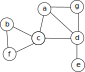

Vertices of $G$:

    ['c', 'b', 'd', 'e', 'a', 'g', 'f']

Edges of $G$:

    [{'c', 'd'}, {'c', 'f'}, {'c', 'b'}, {'f', 'b'}, {'d', 'e'}, {'d', 'g'}, {'c', 'a'}, {'d', 'a'}, {'a', 'g'}]

In [5]:
G_map = {
      "a": ["c", "d", "g"],
      "b": ["c", "f"],
      "c": ["a", "b", "d", "f"],
      "d": ["a", "c", "e", "g"],
      "e": ["d"],
      "f": ["b", "c"],
      "g": ["a", "d"]
}
G = Graph(G_map,"$G$")
display(SVG(filename="small_example.svg"))
display(Markdown('''Vertices of $G$:\n
    ''' + str(G.vertices()))
        , Markdown('''Edges of $G$:\n
    ''' + str(G.edges())))

## Degrees
We then implemented methods related to *node degrees* in a graph:
- `vertex_degree`: returns the degree of a given node;
- `vertex_degrees`: returns a map $V \rightarrow \mathbb{N}$ giving the degree of each node;
- `find_isolated_vertices`: returns list of vertices with degree 0;
- `degree_sequence`: returns a tuple of all values of degrees of the nodes (with repetition) sorted in *decreasing order*;
- `density`: returns the **density** of a graph, which is the number of edges divided by the maximum possible number of edges, i.e. $$\frac{2|E|}{|V|(|V|-1)}.$$


We test these functions over $G$, over $K_5$ (the clique of size 5) and $D_5$ the disconnected graph of size 5.

In [6]:
D5 = G.no_edges(5)
K5 = G.clique(5)
display(Markdown('''Degree of vertex `d` in $G$:\n
    ''' + str(G.vertex_degree("d")))
       ,Markdown('''Degrees of vertices in $G$:\n
    ''' + str(G.vertex_degrees()))
        ,Markdown('''Degree sequence of the $G$:\n
    ''' + str(G.degree_sequence()))
       ,Markdown('''Isolated vertices of $D_5$:\n
    ''' + str(D5.find_isolated_vertices()))
       ,Markdown('''Density of $G$:\n
    ''' + str(G.density()))
       ,Markdown('''Density of $K_5$:\n
    ''' + str(K5.density()))
       ,Markdown('''Density of $D_5$:\n
    ''' + str(D5.density())))

Degree of vertex `d` in $G$:

    4

Degrees of vertices in $G$:

    {'d': 4, 'g': 2, 'c': 4, 'e': 1, 'a': 3, 'b': 2, 'f': 2}

Degree sequence of the $G$:

    (4, 4, 3, 2, 2, 2, 1)

Isolated vertices of $D_5$:

    {1, 2, 3, 4, 5}

Density of $G$:

    0.42857142857142855

Density of $K_5$:

    1.0

Density of $D_5$:

    0.0

The **Erdős–Gallai theorem** gives a sufficient and necessary condition for a given sequence $d_1\geq ...\geq d_n$ to be a valid degree sequence of some G. We implemented it in a static method `erdos_gallai` that checks if the given tuple satisfies the condition.

In [7]:
def display_EG(t):
    if G.erdos_gallai(t):
        return str(t) + " is a valid degree sequence"
    else:
        return str(t) + " is not a valid degree sequence"
display(Markdown(display_EG(G.degree_sequence()))
        , Markdown(display_EG(tuple([2,1]))))

(4, 4, 3, 2, 2, 2, 1) is a valid degree sequence

(2, 1) is not a valid degree sequence

In a graph, a **triplet** consists of three nodes that are connected by either two (open triplet) or three (closed triplet) edges. A **triangle** consists of three closed triplets, each one centered on each node of the triangle. The **global clustering coefficient** of a graph is the number of closed triplets divided by the total number of triplets. Remark that this measure is not defined over graphs with no triplet.

In [8]:
display(Markdown('''Global clustering coefficient of example graph:\n
    ''' + str(G.global_clustering_coefficient()))
       ,Markdown('''Global clustering coefficient of $K_5$:\n
    ''' + str(K5.global_clustering_coefficient())))

Global clustering coefficient of example graph:

    0.5

Global clustering coefficient of $K_5$:

    1.0

## Graph traversal
In this section, we present the function we implemented relying on graph traversal (in all these functions we used the **Breadth First Search** (BFS) traversal method).
### Connected components
We implemented a function `connected_components` which returns a map $V \rightarrow V$ assigning to each node the choosen label of its component (the label is one of the node of the component).

In order to test this function, we define a copy of our example graph in which we had another connected component, call it $G_2$.

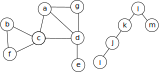

$G_2$ has 2 connected components

In [9]:
G2 = Graph(G_map,"$G_2$")
G2.add_vertex('i')
G2.add_vertex('j')
G2.add_vertex('k')
G2.add_vertex('l')
G2.add_vertex('m')
G2.add_edge({'i','j'})
G2.add_edge({'j','k'})
G2.add_edge({'k','l'})
G2.add_edge({'l','m'})
display(SVG(filename="small_example2.svg"),
        Markdown('$G_2$ has ' + str(len(set(G2.connected_components().values()))) + ' connected components'))

### Diameter
We implemented four functions related to *distances* between nodes in a graph:
- `shortest_path`: returns the length of the shortest path between two nodes of the graph (can be $\infty$);
- `diameter`: returns the length of the longest (non-$\infty$) shortest path between any two pair of nodes;
- `diameter_component`: returns the diameter of the component containing a given node;
- `biggest_component_diameter`: returns the diameter of the biggest component.

With one execution of a BFS starting from a node, we can determine the shortest path between this node and another node, and the maximum shortest path between this node and any other node. Then, for computing the diameter we execute one BFS for each node of the graph (or of the desired component).

In [10]:
def display_length_sp(graph,u,v):
    l = graph.shortest_path(u,v)
    s = "between `" + str(u) + "` and `" + str(v) + "` in " + graph.name()
    if l == math.inf:
        return Markdown("There is no path " + s)
    else:
        return Markdown("The shortest path " + s + " has length " + str(l))
display(display_length_sp(G2,'a','i')
       ,display_length_sp(G2,'a','b')
       ,display_length_sp(G2,'e','b')
       ,display_length_sp(G2,'i','m'))

There is no path between `a` and `i` in $G_2$

The shortest path between `a` and `b` in $G_2$ has length 2

The shortest path between `e` and `b` in $G_2$ has length 3

The shortest path between `i` and `m` in $G_2$ has length 4

In [11]:
display(Markdown("The diameter of the component of `a` in $G_2$ is " + str(G2.diameter_component('a')))
       ,Markdown("The diameter of the component of `i` in $G_2$ is " + str(G2.diameter_component('i')))
       ,Markdown("The diameter of $G_2$ is " + str(G2.diameter()))
       ,Markdown("The diameter of the biggest component of $G_2$ is " + str(G2.biggest_component_diameter()))
       ,Markdown("The diameter of $K_5$ is " + str(K5.diameter()))
       ,Markdown("The diameter of $D_5$ is " + str(D5.diameter())))

The diameter of the component of `a` in $G_2$ is 3

The diameter of the component of `i` in $G_2$ is 4

The diameter of $G_2$ is 4

The diameter of the biggest component of $G_2$ is 3

The diameter of $K_5$ is 1

The diameter of $D_5$ is 0

### Spanning tree
A **spanning tree** of an unweighted and *connected* graph $G = (V,E)$ is a tree whose nodes are $V$ and edges are a subset of $E$ (of size $|V|-1$). We implemented the Prim algorithm for computing a spanning tree of a graph in function `spanning_tree`.

A spanning tree of $G$ is:

    [{'c', 'a'}, {'c', 'b'}, {'c', 'd'}, {'c', 'f'}, {'d', 'e'}, {'d', 'g'}]

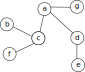

In [12]:
display(Markdown('''A spanning tree of $G$ is:\n
    ''' + str(G.spanning_tree())),
       SVG(filename="small_example_spanning_tree.svg"))

## Testing on real datasets
Finally, we tested some of our functions on bigger graphs, the infamous *Zachary graph* (a connected subset of it in fact) and two random graphs with respectively 100 and 1000 nodes. In order to load these graphs, we added a static method `from_txt` in our `Graph` class that import a graph from a file where each line specifies an edge (two integers separated with a tabulation).

In [13]:
zachary = G.from_txt('zachary_connected.txt')
random100 = G.from_txt('graph_100n_1000m.txt')
random1000 = G.from_txt('graph_1000n_4000m.txt')

In [14]:
Latex(r"""\begin{array}{|c|c|c|c|c|c|} \hline \text{Dataset} & \text{Number of vertices} & \text{Number of edges} & 
\text{Density} & \text{Diameter} & \text{Clustering coefficient} \\ \hline 
\text{Zachary} & """
+ str(len(zachary.vertices())) + r' & '+ str(len(zachary.edges())) + r""" & """
+ str(zachary.density()) + """ & """ + str(zachary.diameter()) + """ & """ + str(zachary.global_clustering_coefficient()) 
+ """ \\\ \hline \\text{Random, } N=10^2 & """
+ str(len(random100.vertices())) + """ & """ + str(len(random100.edges())) + """ & """
+ str(random100.density()) + """ & """ + str(random100.diameter()) + """ & """ + str(random100.global_clustering_coefficient())
+ """ \\\ \hline \\text{Random, }N=10^3 & """
+ str(len(random1000.vertices())) + """ & """ + str(len(random1000.edges())) + """ & """
+ str(random1000.density()) + """ & """ + str(random1000.diameter()) + """ & """ + str(random1000.global_clustering_coefficient()) 
+ """\\\ \hline \end{array}""")

<IPython.core.display.Latex object>

# TP2

In [63]:
import random
import scipy
import scipy.special
import matplotlib
import matplotlib.pyplot as plt;
%matplotlib inline  
plt.rcParams['figure.figsize'] = (15, 6)

In [16]:
def er_np(n, p):
    graph_dict = {}
    for i in range(n):
        graph_dict[i] = []
    for i in range(n):
        for j in range(i):
            rv = random.uniform(0,1)
            if rv < p:
                graph_dict[i].append(j)
                graph_dict[j].append(i)  
    return Graph(graph_dict)

def er_nm(n, m):
    graph_dict = {}
    for i in range(n):
        graph_dict[i] = []
    # number of possible edges (*2 since it is easier to sample couple than pairs)
    nb_possibility = n*n
    count_left = m
    if m > n*(n-1)/2 :
        print("Two many edges asked. Setting right amount.")
        count_left = n*(n-1)/2
    while count_left > 0:
        # sample an index for the new edge
        edge_ind = random.randrange(nb_possibility)
        # get the two endpoints (part where it is easier for couple)
        i = edge_ind // n
        j = edge_ind % n
        # handle loops and multiedges
        if i == j :
            continue 
        if j in graph_dict[i]:
            continue
        graph_dict[i].append(j)
        graph_dict[j].append(i)
        count_left -= 1
    return Graph(graph_dict)

In [17]:
er_np(10,0.5).print()
er_nm(10,111).print()

{0: [1, 5], 1: [0, 2, 4, 8, 9], 2: [1, 3, 5, 6, 7, 9], 3: [2, 4], 4: [1, 3, 6, 9], 5: [0, 2, 6, 9], 6: [2, 4, 5, 7], 7: [2, 6, 9], 8: [1], 9: [1, 2, 4, 5, 7]}
Two many edges asked. Setting right amount.
{0: [8, 1, 2, 4, 5, 3, 7, 6, 9], 1: [5, 0, 3, 4, 8, 2, 6, 7, 9], 2: [0, 8, 9, 3, 6, 7, 5, 1, 4], 3: [7, 8, 6, 2, 1, 5, 9, 0, 4], 4: [0, 7, 8, 1, 9, 6, 2, 3, 5], 5: [1, 7, 9, 3, 0, 8, 2, 6, 4], 6: [7, 3, 2, 1, 4, 0, 9, 5, 8], 7: [3, 6, 4, 5, 8, 2, 0, 1, 9], 8: [0, 2, 9, 3, 4, 7, 1, 5, 6], 9: [2, 8, 5, 3, 4, 6, 1, 7, 0]}


In [18]:
def expected_edge_number(n, p):
    return math.floor(p * n*(n-1)/2)

def binomial_coef(n, k):
    return scipy.special.binom(n, k)
    #n_fact = math.factorial(n)
    #k_fact = math.factorial(k)
    #return n_fact // (k_fact * math.factorial(n-k))

def compare_edge_count(n, p):
    """Generate an er_np graph and compare its edges to an er_nm"""
    m = expected_edge_number(n, p)
    G_tmp = er_np(n, p)
    nb_edges = len(G_tmp.edges())
    if m == 0:
        m = 1
    return nb_edges / m

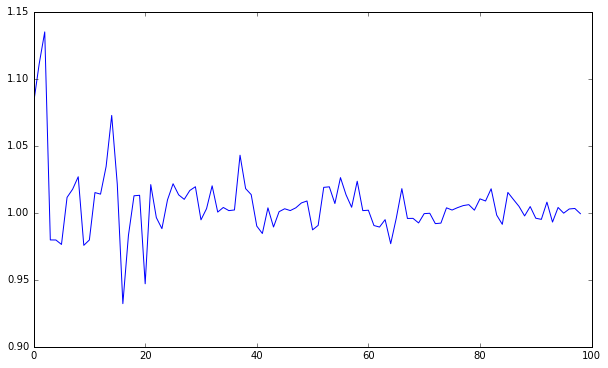

In [58]:
n = 100

# ratio in function of p
got = [ compare_edge_count(n, p) for p in  np.arange(1/n, 1.0, 1/n)]
plt.plot(got)
plt.show()

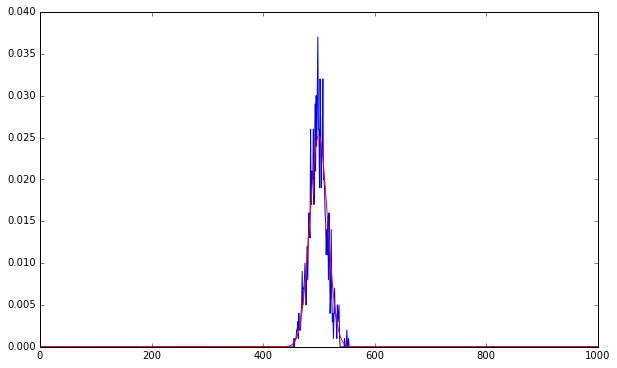

In [59]:
# edge distribution
n = 1000
p = .5
graph_tmp = er_np(n, p)
got = [0 for k in range(n)]
for x in graph_tmp.vertex_degrees().values():
    got[x] += 1
for k in range(n):
    got[k] /= n
plt.plot(got)
expected = [binomial_coef(n-1, k) * math.pow(p, k) * math.pow(1-p, n-1-k) for k in range(n)]
plt.plot(expected, 'r')
plt.show()

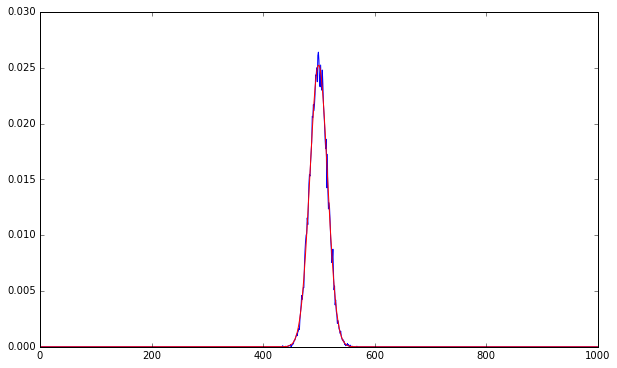

In [60]:
# averages edge distribution
n = 1000
nb = 20
p = .5

got = [0 for k in range(n)]

for i in range(nb):
    graph_tmp = er_np(n, p)
    for x in graph_tmp.vertex_degrees().values():
        got[x] += 1
for k in range(n):
    got[k] /= n * nb
plt.plot(got)
expected = [binomial_coef(n-1, k) * math.pow(p, k) * math.pow(1-p, n-1-k) for k in range(n)]
plt.plot(expected, 'r')
plt.show()

In [61]:
def biggest_comp_size(G):
    comps = G.connected_components()
    # First determine the biggest component #
    comps_size = {}
    for u in comps.values():
        comps_size[u] = 0
    for v,u in comps.items():
        comps_size[u] += 1
    biggest = tuple(comps.values())[0]
    max_size = comps_size[biggest]
    for u in comps.values():
        if comps_size[u] > max_size:
            max_size = comps_size[u]
            biggest = u
    return max_size

def second_biggest_comp_size(G):
    comps = G.connected_components()
    # First determine the biggest component #
    comps_size = {}
    for u in comps.values():
        comps_size[u] = 0
    for v,u in comps.items():
        comps_size[u] += 1
    biggest = tuple(comps.values())[0]
    max_size = comps_size[biggest]
    for u in comps.values():
        if comps_size[u] > max_size:
            max_size = comps_size[u]
            biggest = u
    sec_size = 0
    for u in comps.values():
        if u == biggest:
            continue
        else:
            if comps_size[u] > sec_size:
                sec_size = comps_size[u]
    return sec_size

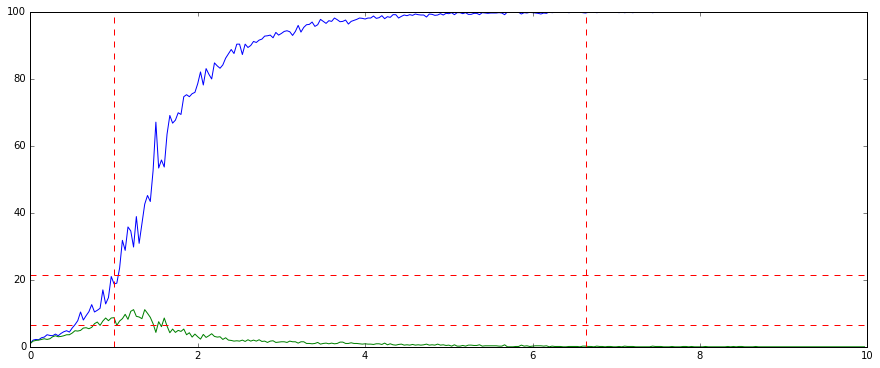

In [65]:
#2
# TODO : rendre le truc plus dynamique
n = 100
nb_average = 10
step = 300
end_point = 10

bcomp_size = [0 for i in range(step)]
sec_size = [0 for i in range(step)]
x = [0 for i in range(step)]
for t in range(nb_average):
    for i in range(step):
        p = end_point * i / (step * n) 
        x[i] = n * p
        G = er_np(n, p)
        bcomp_size[i] += biggest_comp_size(G)
        sec_size[i] += second_biggest_comp_size(G)
bcomp_size = [x / nb_average for x in bcomp_size]
sec_size = [x / nb_average for x in sec_size]

plt.plot(x, bcomp_size)
plt.plot(x, sec_size)

vert_line_data = np.array([math.pow(n, 2/3) for i in range(2)])
plt.plot([0,end_point] , vert_line_data, 'r--') 

plt.plot([1,1] , [0,n], 'r--') 
plt.plot( [0,end_point], [math.log(n, 2),math.log(n, 2)], 'r--') # log2 ou ln ??
plt.plot( [math.log(n, 2),math.log(n, 2)], [0,n], 'r--') # log2 ou ln ??

plt.show()

In [67]:
#3
def degree_sequence_regular(n, k):
    return [k for i in range(n)]

def degree_sequence_lognormal(n, mu, sigma):
    return [math.floor(random.lognormvariate(mu, sigma)) for i in range(n)]